# Action Space for RL Agent.

This notebook contains the various actions available for the RL Agent.

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fn='images/city2_hazy.png'

In [3]:
src = cv2.imread(fn)
# read the image

# use astype to cast image to float 64 values
I = src.astype("float64") / 255

In [4]:
def showImg(img):
    plt.imshow(img), plt.axis("off")
    plt.show()

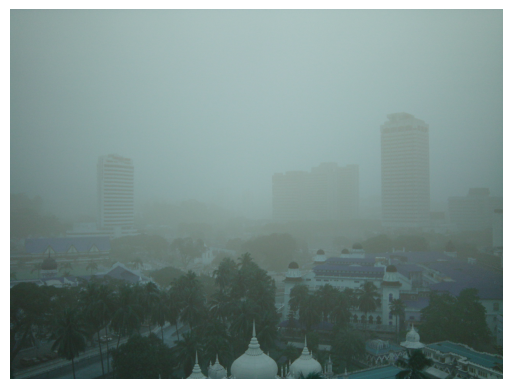

In [5]:
showImg(src)

# Contrast Enhancement

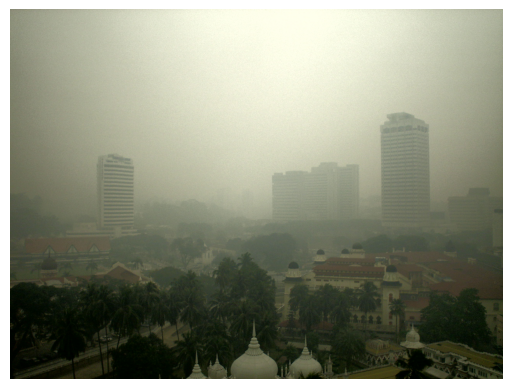

In [6]:
image_yuv = cv2.cvtColor(src, cv2.COLOR_BGR2YUV)
image_yuv[:, :, 0] = cv2.equalizeHist(image_yuv[:, :, 0])
image_rgb = cv2.cvtColor(image_yuv, cv2.COLOR_YUV2RGB)
plt.imshow(image_rgb), plt.axis("off")
plt.show()

# Gamma Correction/Transform

In [7]:
def gammaCorrection(src, gamma):
    invGamma = 1 / gamma

    table = [((i / 255) ** invGamma) * 255 for i in range(256)]
    table = np.array(table, np.uint8)

    return cv2.LUT(src, table)

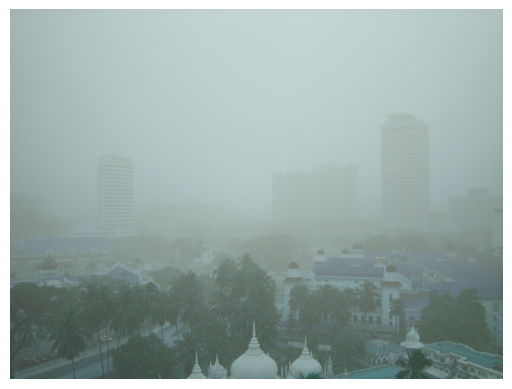

In [8]:

gammaImg = gammaCorrection(src, 1.5)
plt.imshow(gammaImg), plt.axis("off")
plt.show()

# Color Channle Value

In [9]:
def ChannelValue(img,val,channel):
    img_channel=img[:,:,channel]
    img_channel[img_channel*val<255]=img_channel[img_channel*val<255]*1.05
    img_channel[img_channel*val>=255]=255
    img[:,:,channel]=img_channel[:]
    return img


In [10]:
RGB=cv2.cvtColor(src,cv2.COLOR_BGR2RGB)

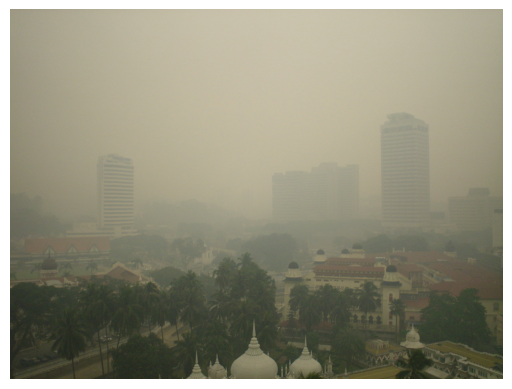

In [11]:
NewRGB=ChannelValue(RGB,1.05,0)
showImg(NewRGB)

# Dehazing : Dark Channel Prior

In [12]:
from DehazingDarkChannelPrior.dehaze import *

In [13]:
I = src.astype("float64") / 255
    # normalizing the data to 0 - 1 (Since 255 is the maximum value)

dark = DarkChannel(I, 15)
# extracting dark channel prior
A = AtmLight(I, dark)
# extracting global atmospheric lighting
# Transmission is an estimate of how much of the light from the
# original object is making it through the haze at each pixel
te = TransmissionEstimate(I, A, 15)
t = TransmissionRefine(src, te)
# atmospheric light is subtracted from each pixel in proportion to the transmission at that pixel.
J = Recover(I, t, A, 0.1)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


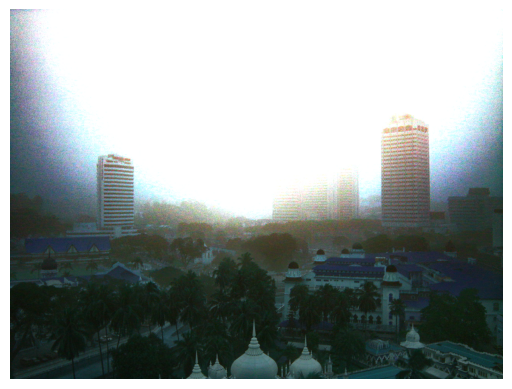

In [14]:
showImg(J)

# Dehazing: Color Attentuation

In [15]:
from DehazingColorAttenuation.dehaze import *

In [16]:
# Read the Image
# _I = cv2.imread(fn)
# opencv reads any image in Blue-Green-Red(BGR) format,
# so change it to RGB format, which is popular.
I = cv2.cvtColor(src, cv2.COLOR_BGR2RGB)
# Split Image to Hue-Saturation-Value(HSV) format.
H, S, V = cv2.split(cv2.cvtColor(src, cv2.COLOR_BGR2HSV))
V = V / 255.0
S = S / 255.0

# Calculating Depth Map using the linear model fit by ZHU et al.
# Refer Eq(8) in mentioned research paper
# Values given under EXPERIMENTS section
theta_0 = 0.121779
theta_1 = 0.959710
theta_2 = -0.780245
sigma = 0.041337
epsilon = np.random.normal(0, sigma, H.shape)
D = theta_0 + theta_1 * V + theta_2 * S + epsilon

# saving depth map
# plt.imsave(os.path.join(filepath, filename + "_depth_map.jpg"), D)

# Local Minima of Depth map
LMD = localmin(D, 15)
# LMD = D

# Guided Filtering
r = 8
# try r=2, 4, 8 or 18
eps = 0.2 * 0.2
# try eps=0.1^2, 0.2^2, 0.4^2
# eps *= 255 * 255;   # Because the intensity range of our images is [0, 255]
GD = guide(D, LMD, r, eps)

J = postprocessing(GD, I,V)



Atmosphere A = (r, g, b)
[0.7254902  0.73333333 0.63921569]


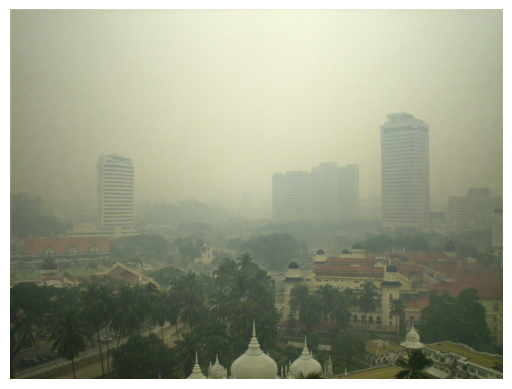

In [17]:
showImg(J)